# 프로젝트 : 임베딩 내 편향성 알아보기

## 1. 데이터 준비하기

## 2. 단어 셋 만들기
- **타겟 단어 셋**
- **속성 단어 셋**

## 3. 편향성 확인하기

In [ ]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


- - -
### 데이터 준비하기

In [ ]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [ ]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)


print(len(tokenized))

71156


형태소 분리를 하고 데이터에서 명사만 추출해줍니다.

In [ ]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8899760246276855),
 ('다큐멘터리', 0.8573907613754272),
 ('드라마', 0.8168043494224548),
 ('영화로', 0.8157266974449158),
 ('코미디', 0.7904950380325317),
 ('소재', 0.7863573431968689),
 ('형식', 0.7808390259742737),
 ('감동', 0.7792397737503052),
 ('스토리', 0.7678096890449524),
 ('인터뷰', 0.7667863368988037)]

추출한 명사들을 가지고 임베딩 모델을 만들어줍니다.

`model.wv.most_similar`를 이용해 '영화'와 밀접한 뜻을 가진 단어들을 출력해봤습니다.

제가 예상한 드라마라는 단어가 있군요.

In [ ]:
model.wv.most_similar(positive=['판타지'])

[('스토리', 0.941171407699585),
 ('시적', 0.938279390335083),
 ('감동', 0.9309855699539185),
 ('주제', 0.9301994442939758),
 ('코믹', 0.9297823309898376),
 ('선사', 0.9283303618431091),
 ('스크린', 0.9216429591178894),
 ('캐릭터', 0.9186232089996338),
 ('해석', 0.9142426252365112),
 ('탐구', 0.9127894043922424)]

영화라는 단어는 너무 큰 틀에 있는 것 같으니까 '판타지'라는 단어와 비슷한 뜻을 가진 단어도 출력해봤습니다.

제법 유사한 것 같습니다.

- - -
### 단어 셋 만들기
- **타겟 단어 셋**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def read_token(file_name, genre_name):
    result = {}
    
    for file, name in zip(file_name, genre_name):
        with open(os.getenv('HOME')+'/aiffel/weat/' + file, 'r') as fread: 
            print(file, '파일을 읽고 있습니다.')
            tokens = []
            while True:
                line = fread.readline() 
                if not line: break 
                tokenlist = okt.pos(line, stem=True, norm=True)
                for word in tokenlist:
                    if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                        tokens.append((word[0]))
            result[name] = ' '.join(tokens)
                        
    return result

준비된 장르별 문장에서 그 장르에 쓰였던 명사를 추출해서 담아주는 함수입니다.

In [ ]:
division_txt = ['synopsis_art.txt', 'synopsis_gen.txt']
division_name = ['예술영화', '일반영화']

division_tokens = read_token(division_txt, division_name)

art = division_tokens['예술영화']
gen = division_tokens['일반영화']

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


먼저 큰 분류로 예술영화 일반영화가 준비되어있으니 타겟 셋으로 사용해줍니다.

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [ ]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


두 문서의 TF-IDF 단어 벡터 셋으로 만들어줬습니다.

In [ ]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

`get_feature_names`를 이용해 인덱스를 단어로 바꿔 저장하고, 장르를 가장 잘 표현하고 있는 단어 순으로 정렬을 해줬습니다.

In [ ]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [ ]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [ ]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


하지만 예술영화로도 표현이 가능하고 일반영화로도 표현되고 있는 중복된 단어들이 너무 많아

예술영화를 표현하지만 일반영화를 표현하지는 않는, 일반영화를 표현하지만 예술영화를 표현하지는 않는

중복을 제거한 후 상위 15개의 제대로 된 단어만 담아줬습니다.

- - -
### 단어 셋 만들기
- **속성 단어 셋**

In [ ]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

genre_tokens = read_token(genre_txt, genre_name)

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list(genre_tokens.values()))

print(X.shape)

(21, 42191)


In [ ]:
for i, k in enumerate(genre_tokens):
    w = X[i].tocoo()
    w = [[l, j] for l, j in zip(w.col, w.data)]
    w.sort(key=lambda x: x[1], reverse=True)
    genre_tokens[k] = w


for i in genre_tokens['SF'][:30]:
    print(vectorizer.get_feature_names()[i[0]], end=', ')

위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 정체, 친구, 비밀, 사실, 기억, 전쟁, 사건, 시간, 공격, 영화, 

In [ ]:
for k, v in genre_tokens.items():
    genre_tokens[k] = [vectorizer.get_feature_names()[i[0]] for i in v[:100] if vectorizer.get_feature_names()[i[0]] in model.wv]

genre_tokens['드라마'][:30]

['자신',
 '영화제',
 '그녀',
 '사람',
 '사랑',
 '영화',
 '위해',
 '시작',
 '국제',
 '남자',
 '친구',
 '이야기',
 '엄마',
 '여자',
 '아버지',
 '가족',
 '단편',
 '서울',
 '대한',
 '아들',
 '마음',
 '아이',
 '남편',
 '서로',
 '시간',
 '소녀',
 '세상',
 '감독',
 '다른',
 '모든']

여러가지 소분류 장르의 단어 셋도 만들어줍니다.

마찬가지로 단어가 꼭 많을 필요는 없으니 상위 100개의 단어만 넣어줍시다.

이후에 중복 제거 처리를 거치면 단어가 줄어들테니 너무 적으면 안되고,

또 너무 많으면 단어가 중복될 확률이 많아지는데다가, 연산 처리에 시간이 너무 많이 소모되니 적당하게 100개로 잡았습니다.

- - -
### 편향성 확인하기

In [ ]:
genre_unique = [[] for i in range(len(genre_name))]

for i, k in enumerate(genre_tokens):
    for j, v in enumerate(genre_tokens.values()):
        if i != j:
            genre_unique[i] += v


for i, k in enumerate(genre_tokens):
    for word_unique in set(genre_unique[i]):
        genre_unique[i].remove(word_unique) # 단어를 한 번씩 지움으로써 두 번 이상 중복되는 것만 제거
    
    if k == '드라마' or k == '스릴러': # '드라마'와 '스릴러'는 한 번 더(중복이 세 번 이상인지)
        for word_unique in set(genre_unique[i]):
            genre_unique[i].remove(word_unique)
    
    genre_tokens[k] = [token for token in genre_tokens[k] if token not in genre_unique[i]]

In [ ]:
for k, v in genre_tokens.items():
    print(k, ': ', end='')
    for i in v[:15]:
        print(i, end=', ')
    print()

SF : 인류, 로봇, 박사, 우주선, 외계, 행성, 실험, 능력, 시스템, 생명체, 정부, 스타크, 리플리, 과학자, 음모, 
가족 : 아주르, 낙타, 씨제이, 동구, 슈이트, 어머니, 마갈, 미아, 펠리칸, 벤트, 케이시, 엠마, 고양이, 크리스마스, 최호, 
공연 : 오페라, 토스카, 실황, 올레, 카바, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 콘서트, 백작부인, 반니, 
공포(호러) : 악령, 좀비, 저주, 일행, 악몽, 병원, 유령, 귀신, 악마, 저택, 바이러스, 이사, 현상, 사라, 영혼, 
기타 : 뉴미디어, 페스티벌, 아시아나, 이미지, 상영작, 지하철, 청소년, 유럽, 노인, 공간, 포럼, 메트로, 단편영화, 풍경, 사진, 
다큐멘터리 : 다큐, 다큐멘터리, 환경, 노동자, 기록, 카메라, 과정, 투쟁, 인디다큐페스티발, 지금, 북한, 현재, 일본, 문화, 건축, 
드라마 : 부문, 연출, 어머니, 독립, 인생, 부산, 일상, 의도, 감정, 한국, 경쟁, 상처, 사회, 처음, 시절, 
멜로로맨스 : 유혹, 연애, 애인, 새엄마, 불륜, 남자친구, 유부녀, 감정, 정사, 출장, 선배, 여자친구, 커플, 만난, 고백, 
뮤지컬 : 뮤지컬, 에스메랄다, 충무로, 모차르트, 토스카, 니웨, 카바, 바흐, 페뷔스, 프롤, 모도, 카르피, 제루샤, 샤오캉, 데이비, 
미스터리 : 민혁, 미스터리, 현우, 방독면, 소설, 사진, 랭던, 몰카, 자살, 혼란, 지목, 병원, 누군가, 불명, 거미숲, 
범죄 : 범죄, 마약, 한길수, 은행, 마피아, 프랭크, 감옥, 파푸아, 금고, 교도소, 테러범, 강도, 마샨, 거래, 달러, 
사극 : 조선, 신기전, 아가멤논, 황제, 루안, 하선, 윤서, 트로이, 세자, 허균, 노준, 채선, 신재효, 히파티아, 권력, 
서부극(웨스턴) : 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 개릿, 무법자, 프린트, 마적, 태구, 현상금, 분노, 버질, 랜던, 
성인물(에로) : 마사지, 정사, 유부녀

먼저 속성 단어 셋의 중복을 제거해줬습니다.

해당하지 않는 장르의 모든 단어를 모으고 해당하는 장르와 비교해 유니크함이 확인되면 리스트에 담는 원리입니다.

단, 드라마와 스릴러라는 장르를 표현하는 단어는 중복이 너무 많아서 특별처리했습니다.

    세트의 차집합을 사용하면 가나다 순으로 정렬이 되어버리는 문제 때문에 이와 같은 방식을 채택했습니다.

In [ ]:
min([len(l) for l in genre_tokens.values()])

13

중복 제거 후 가장 적은 단어를 가진 장르는 13개의 단어를 가지고 있습니다.

In [ ]:
min_len = 13
attributes = []

for tokens in genre_tokens:
    attributes.append(genre_tokens[tokens][:min_len])

for i in attributes:
    print(i)

['인류', '로봇', '박사', '우주선', '외계', '행성', '실험', '능력', '시스템', '생명체', '정부', '스타크', '리플리']
['아주르', '낙타', '씨제이', '동구', '슈이트', '어머니', '마갈', '미아', '펠리칸', '벤트', '케이시', '엠마', '고양이']
['오페라', '토스카', '실황', '올레', '카바', '오텔로', '리골레토', '백작', '프레', '베르디', '카르피', '비바', '콘서트']
['악령', '좀비', '저주', '일행', '악몽', '병원', '유령', '귀신', '악마', '저택', '바이러스', '이사', '현상']
['뉴미디어', '페스티벌', '아시아나', '이미지', '상영작', '지하철', '청소년', '유럽', '노인', '공간', '포럼', '메트로', '단편영화']
['다큐', '다큐멘터리', '환경', '노동자', '기록', '카메라', '과정', '투쟁', '인디다큐페스티발', '지금', '북한', '현재', '일본']
['부문', '연출', '어머니', '독립', '인생', '부산', '일상', '의도', '감정', '한국', '경쟁', '상처', '사회']
['유혹', '연애', '애인', '새엄마', '불륜', '남자친구', '유부녀', '감정', '정사', '출장', '선배', '여자친구', '커플']
['뮤지컬', '에스메랄다', '충무로', '모차르트', '토스카', '니웨', '카바', '바흐', '페뷔스', '프롤', '모도', '카르피', '제루샤']
['민혁', '미스터리', '현우', '방독면', '소설', '사진', '랭던', '몰카', '자살', '혼란', '지목', '병원', '누군가']
['범죄', '마약', '한길수', '은행', '마피아', '프랭크', '감옥', '파푸아', '금고', '교도소', '테러범', '강도', '마샨']
['조선', '신기전', '아가멤논', '황제', '루안', '하선', '윤서', '트로이', '세자'

각 장르의 단어 크기가 제각각이면 제대로 된 비교가 되지 못할까봐 모든 장르의 단어 수를 13개로 제한하고 새로운 리스트에 담아줬습니다.

중복이 어느 정도 제거되니 키워드만 봐도 어느 장르인지 대충 짐작이 갑니다.

In [ ]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [ ]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [ ]:
import numpy as np

X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [ ]:
weat_matrix = []

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])
        weat_matrix.append([genre_name[i], genre_name[j],matrix[i][j]])

SF 가족 -1.0850898
SF 공연 -0.338183
SF 공포(호러) -1.0223193
SF 기타 0.21435021
SF 다큐멘터리 0.12758997
SF 드라마 -0.25781307
SF 멜로로맨스 -0.9170792
SF 뮤지컬 -0.16385804
SF 미스터리 -0.95030934
SF 범죄 -0.5519176
SF 사극 -0.69056463
SF 서부극(웨스턴) -1.0403636
SF 성인물(에로) -0.7576695
SF 스릴러 -0.839494
SF 애니메이션 -0.16327226
SF 액션 -0.63033336
SF 어드벤처 -1.0652823
SF 전쟁 -0.17122258
SF 코미디 -0.86570626
SF 판타지 -1.2292254
가족 공연 0.8090934
가족 공포(호러) 0.12917715
가족 기타 0.95096654
가족 다큐멘터리 0.89178586
가족 드라마 0.8641469
가족 멜로로맨스 -0.47176856
가족 뮤지컬 0.8775204
가족 미스터리 0.27446866
가족 범죄 0.7612644
가족 사극 0.9362397
가족 서부극(웨스턴) 0.8827341
가족 성인물(에로) -0.043271903
가족 스릴러 0.18135288
가족 애니메이션 0.92746645
가족 액션 0.89272225
가족 어드벤처 0.73769015
가족 전쟁 0.9471667
가족 코미디 0.12173177
가족 판타지 0.28341046
공연 공포(호러) -0.52511823
공연 기타 0.88142323
공연 다큐멘터리 0.49420264
공연 드라마 0.12742771
공연 멜로로맨스 -0.8104689
공연 뮤지컬 1.0150241
공연 미스터리 -0.556789
공연 범죄 -0.16247045
공연 사극 -0.29173446
공연 서부극(웨스턴) -0.54623127
공연 성인물(에로) -0.6376557
공연 스릴러 -0.44750506
공연 애니메이션 0.4466841
공연 액션 -0.00744800

WEAT score를 계산한 결과입니다.

절댓값이 높을수록 예술영화 일반영화 중 한 쪽으로 편향적이다 라고 볼 수 있습니다.

In [ ]:
weat_matrix.sort(key=lambda x: abs(x[2]), reverse=True)

for i in weat_matrix[:10]:
    print(i[0], i[1], i[2])

멜로로맨스 성인물(에로) 1.2677941
SF 판타지 -1.2292254
SF 가족 -1.0850898
SF 어드벤처 -1.0652823
전쟁 판타지 -1.056604
액션 판타지 -1.0407199
SF 서부극(웨스턴) -1.0403636
SF 공포(호러) -1.0223193
뮤지컬 코미디 -1.0216529
기타 코미디 -1.0166525


두 장르를 조합했을 때의 평균값이 가장 편향성을 나타내는 장르 상위 10가지를 출력해봤습니다.

이렇게 봤을 때는 아직 그럴듯한 결과를 얻기는 힘들어보입니다.

<AxesSubplot:>

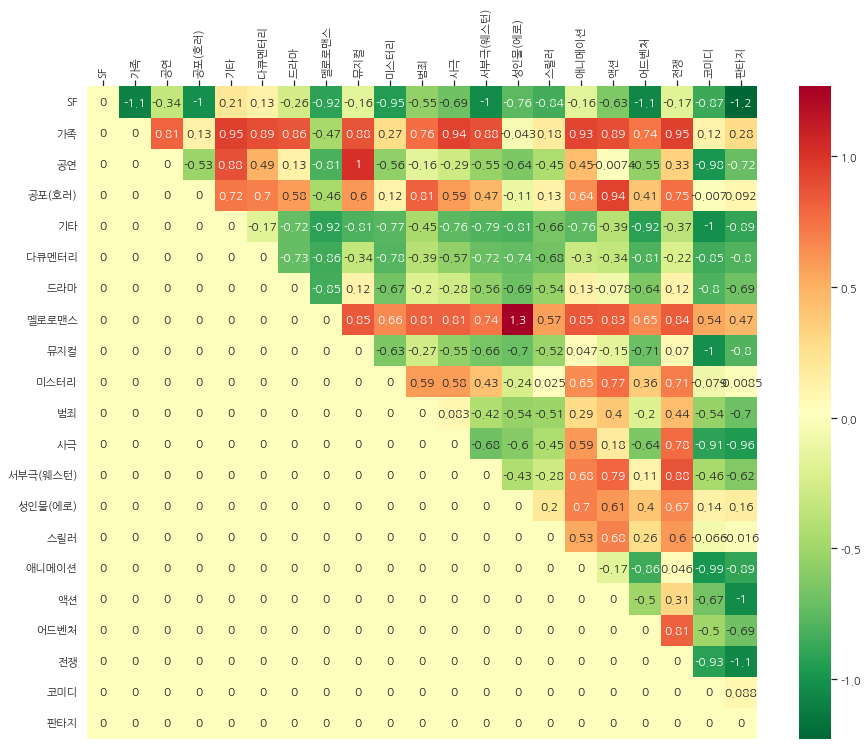

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15, 12))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax.xaxis.tick_top() # x라벨을 그래프의 위에 표시하기
plt.xticks(rotation=90) # x라벨의 문자를 90도로 기울이기
ax

결과를 히트맵으로 표현하면 위와 같습니다.

두 장르의 조합 중 하나의 장르만 성향이 한 쪽으로 짙어도 대체로 그 장르의 성향을 따라가는 현상도 보입니다.

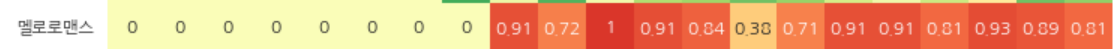

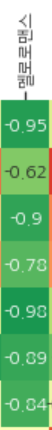

## 마무리하며

TF-IDF의 문제점이라고 생각되는 부분은 딱히 떠오르는 부분이 없습니다.

그나마 편향성 확인을 위해 진행하면서 생긴 문제점이라고는 중복된 단어를 부여한다는 것 뿐인데요.

진행한 프로젝트처럼 단어의 클래스를 분류하려는 목적 외에는 발생해도 큰 영향이 없는 문제인 듯 싶은데다가,

중복 제거 처리를 직접 진행하면 쉽게 해결 될 문제인 것 같습니다. 저도 어렵지 않게 해결했기도 하구요.

편향성을 보는 방법은 사실 아직 이해가 잘 안가는 부분이 많아서 프로젝트가 제대로 만들어졌나 모르겠습니다.